# Rockfall localization
This notebook presents an algorithm for the localization of rockfalls by means of recorded seismic signals. You are very welcomed to play around and test the influence of different parameters on the rockfall location probability!

The here presented rockfalls occured at the flanks of Dolomieu crater on Piton de la Fournaise volcano, La Réunion. Seismic signals generated by the rockfalls were recorded at 4 seismic stations surrounding the crater. 
![Dolomieu map](images/map_RF_examples.png)
You can find the signals of 2 exemplary events in folder `data/signals/`. 

The localization method is based on the comparison between observed and simulated energy ratios of station pairs. Simulations of the seismic wave propagation were carried out using the Spectral Element Methos (SEM). For this, an Earth model was created with the topography of Dolomieu crater and realistic subsurface properties. In order to explore the rockfall locations which best fit the data, a grid of potential source positions was defined. This way, we hold information of the seismic energy generated by each source position for each component (east E, north N, vertical Z) of each seismic station. The synthetic energy values are stored in `data/simu/`.

By analysing the observed seismic signals with a sliding time window, we can gain insight in the spatio-temporal evolution of the rockfall. This is really cool! We will visualize the most probable rockfall positions as a function of time on a map using a 2D colormap. 

I admit that this is a very brief introduction to the method. Nevertheless, you can start exploring and test for example the sensitivity of the localization on the width of the sliding time window, on the influence of site effects, or using only vertical components vs. using all 3 components. 

Have fun!

In [2]:
# Adjust notebook style
from IPython.core.display import HTML
css_file = 'style.css'
HTML(open(css_file,'r').read())

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline   
# import modules
import numpy as np
from obspy import read, Stream
from obspy.core import UTCDateTime
from matplotlib.dates import num2date
from modules.m_PLOTS import *
from modules.m_PickTW import cd, pickTW
from modules.m_PROB import calc_prob
from modules.m_SEdeconv import deconvolve_SE
import os
import time

### Define Parameters
You can select the following values for each parameter:

| Parameter     | Value       | Function  |
| ------------- |-------------| ----------|
| *event*   | '2016.348', '2017.022'| Choose between 2 rockfalls |
| *nearSTA* | 'BOR', 'BON'          |  Closest station according to *event* |
| *chID*    | 'Z', 'ENZ'            | Only vertical or 3 components |
| *site_eff_deconv* | True, False | Site effect correction of signals |
| *lwin*  | float | Length (seconds) of sliding time window |
| *swin*  | float | Step size (seconds) of sliding time window |
| *freqband* | [fmin, fmax] | Corner values (Hertz) of frequency band which is used for localization  |


In [15]:
# You are welcomed to play around with the following parameters
event   = '2016.348'
chID    = 'ENZ'  
nearSTA = 'BOR'
site_eff_deconv = True 

lwin = 4.
swin = 2.

# As of now you cannot play around with the frequency band
freqband = [13., 17.]

# You better DON'T play around with the grid dimensions
xdim = 121
ydim = 101

### Load rockfall signals
The rockfall seismic signals are loaded using obspy. All signals are stored as *Traces* in a *Stream*.

In [16]:
# Create Stream with all signals
st = Stream()
if   chID == 'ENZ':
        channels = [ 'Z','N','E']
elif chID == 'Z':
        channels = [ 'Z']
path_event = 'data/signals/'+event+'/'
for ch in channels:
    st += read(path_event+"/PF.*"+ch+".D.20*.VEL")
# Pre-filter the signal:
st.filter('bandpass', freqmin=1., freqmax=40.,
                    corners = 2, zerophase = 'true')
# Determine starttime t0
t0 = st[0].stats.starttime
eventDate = (str(t0.year)+'-'+str(t0.month).zfill(2)+'-'+
             str(t0.day).zfill(2)+'  '+str(t0.hour).zfill(2)+':'+
             str(t0.minute).zfill(2)+':'+str(t0.second).zfill(2))
print(st)

10 Trace(s) in Stream:
PF.BON.00.HHZ | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHZ | 2016-12-13T11:08:45.003131Z - 2016-12-13T11:10:45.003131Z | 100.0 Hz, 12001 samples
PF.DSO.90.EHZ | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHZ | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 100.0 Hz, 12001 samples
PF.BON.00.HHN | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHN | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHN | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 100.0 Hz, 12001 samples
PF.BON.00.HHE | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHE | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHE | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 1

Let's have a first look on the rockfall signals!

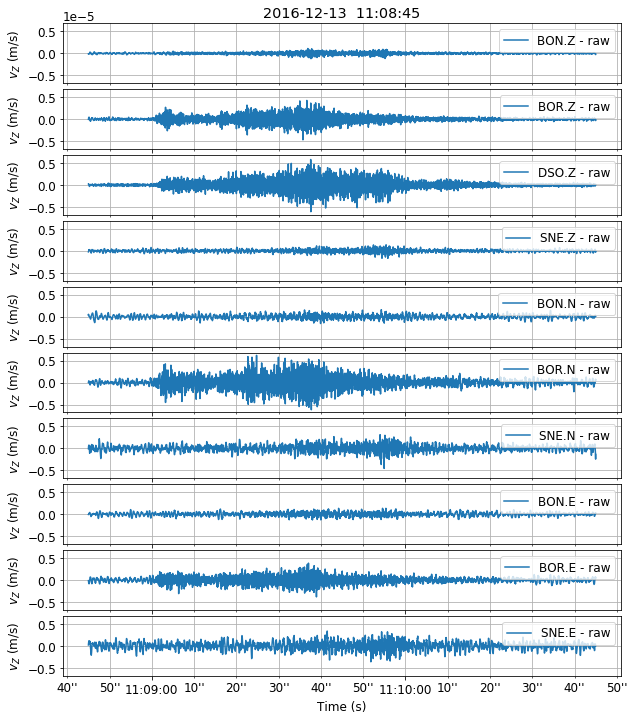

In [17]:
plot_traces([st],['raw'],eventDate)

### Processing the signals
The signal at a station can be amplified due to the local soil structure. This can bias the localization when the stations are differently influenced. In order to aboid this bias, we have to remove these site effects from the recorded signals. This can be done by deconvolution in the time domain, which becomes a division in the frequency domain. 

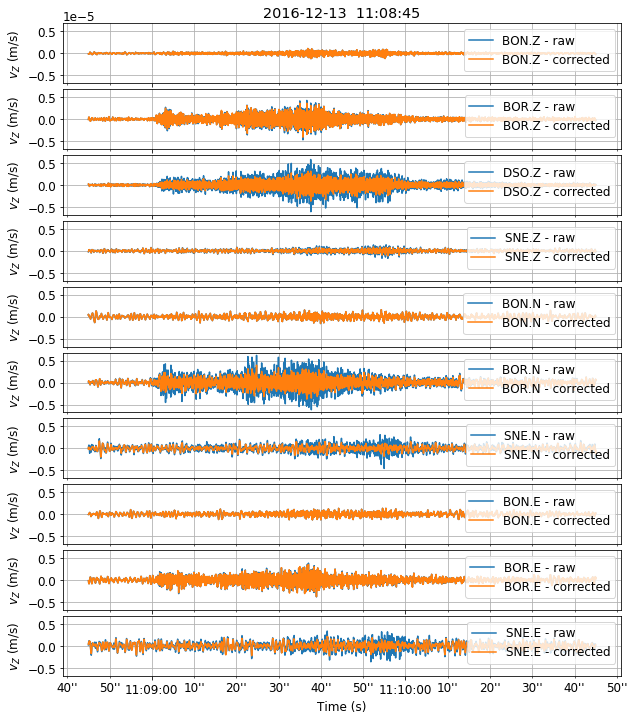

In [18]:
# Site effect deconvolution
if site_eff_deconv:
    st_raw = st.copy()
    # We remove the site effects from each trace tr:
    for tr in st:
        tr = deconvolve_SE(tr)
    # Plotting the site corrected signals
    plot_traces([st_raw,st],['raw','corrected'],eventDate)

You can see that in particular station SNE was amplified. After the site effect correction we hope that the localization is less biased.

In the following we band-pass filter the signals in the frequency band in which observed and simulated energy ratios will be compared.

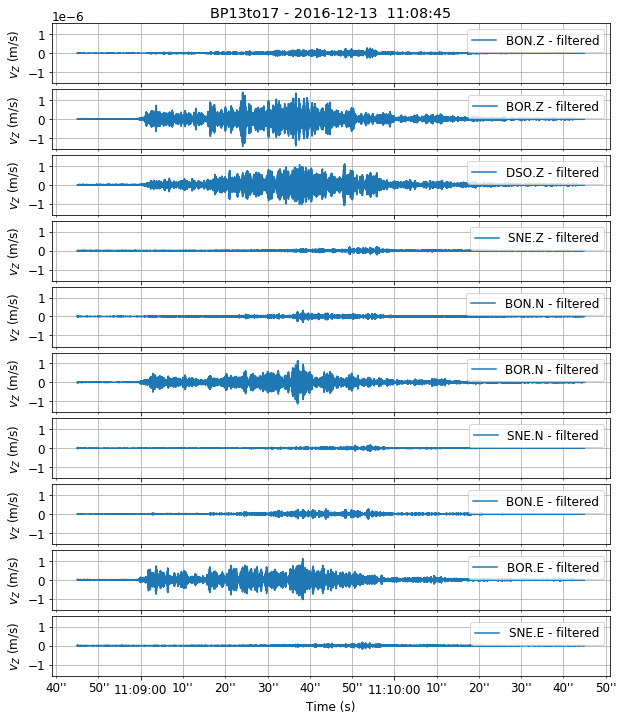

In [8]:
# Band-pass filtering the signals
freqmin = freqband[0]
freqmax = freqband[1]
freqID  = 'BP'+str(int(freqmin))+'to'+str(int(freqmax))
st.filter('bandpass', freqmin=freqmin, freqmax=freqmax,
                    corners = 2, zerophase = 'true')
plot_traces([st],['filtered'],freqID+' - '+eventDate)

### Pick start and end time of rockfall signal
Let's pick the time window of the signal which shall be used to localize the rockfall.

<IPython.core.display.Javascript object>


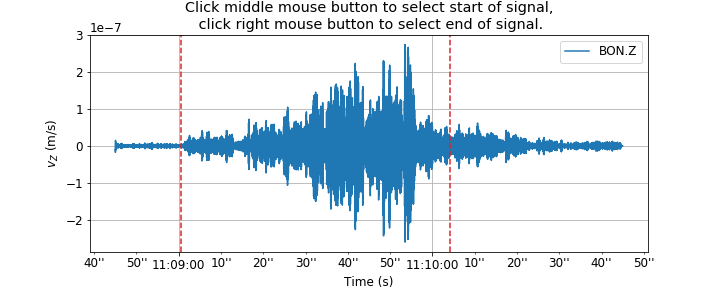

In [11]:
if os.path.isfile('pickedTW_'+event+'.txt'):
    newPick = False
    print('File with picked time window already exists.')
    plot_trace(st.select(station=nearSTA,channel='*Z')[0],event)
else:
    # Activate interactive plotting:
    %matplotlib notebook
    %matplotlib notebook  
    import matplotlib.pyplot as plt
    newPick = True
    pickTW(st.select(station=nearSTA,channel='*Z')[0], path_event)

Load the previously picked time window.

In [12]:
# Only in case of newly picked time window
if newPick:
    # Rename file with picked time window according to event:
    os.rename('pickedTW.txt', 'pickedTW_'+event+'.txt')
    # Deactivate interactive plotting:
    %matplotlib inline
    %matplotlib inline  
    import matplotlib.pyplot as plt

# Load time window
pickedTW = np.loadtxt('pickedTW_'+event+'.txt')
tstart = UTCDateTime(num2date(pickedTW[0]))
tend   = UTCDateTime(num2date(pickedTW[1]))
print('Starttime: ', tstart)
print('Endtime:   ', tend)

Starttime:  2016-12-13T11:09:00.575999Z
Endtime:    2016-12-13T11:10:04.166400Z


### Location optimazation

In [13]:
probs = np.zeros((ydim,xdim))
times = np.zeros((ydim,xdim))

offset  = (tstart+swin-lwin/2) - t0
t1 = time.time()
print('Sliding time window (TW):')
for iTW, windowed_st in enumerate( st.slide(
                                    window_length=lwin, 
                                    step=swin,
                                    offset=offset, 
                                    include_partial_windows=True )):
    if (windowed_st[0].stats.starttime+lwin/2) > tend:
        break
    print('TW ', iTW)
     
    probs_tw = calc_prob(windowed_st, channels, ydim, xdim, freqID)
                               
    if iTW == 0:
        t_rel = 0.
        times[:,:] = t_rel
        probs = probs_tw
    else:
        t_rel += swin
        for ii in range(ydim):
            for jj in range(xdim):
                if probs[ii,jj] < probs_tw[ii,jj]:
                    times[ii,jj] = t_rel
                    probs[ii,jj] = probs_tw[ii,jj]
t2 = time.time()
print('Elapsed time: ', (t2-t1),'s')

Sliding time window (TW):
TW  0
TW  1
TW  2
TW  3
TW  4
TW  5
TW  6
TW  7
TW  8
TW  9
TW  10
TW  11
TW  12
TW  13
TW  14
TW  15
TW  16
TW  17
TW  18
TW  19
TW  20
TW  21
TW  22
TW  23
TW  24
TW  25
TW  26
TW  27
TW  28
TW  29
TW  30
Elapsed time:  19.263001203536987 s


### Result Visualization

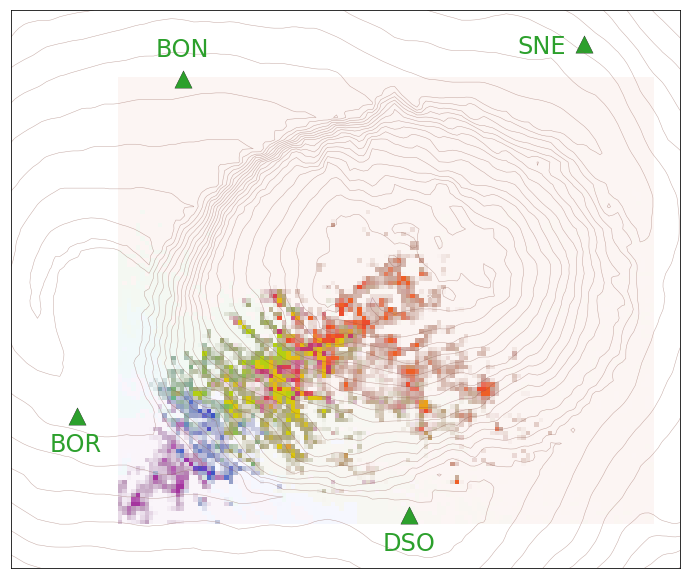

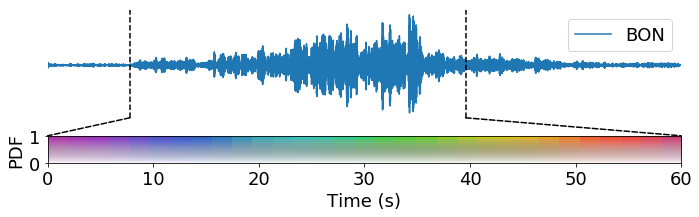

In [14]:
loc_prob_time   = np.array([np.flipud(times), np.flipud(probs)/10.])

plot_LOCA(loc_prob_time, t_rel, swin)
plot_Tr_Cb(st.select(station=nearSTA,channel='*Z')[0], 
           pickedTW[0], pickedTW[1], t_rel, swin)

## Conclusions